In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
sns.set()

In [147]:

def readAtomicTimes(file_path):
    names=['name', 'blocks','threads','iterations','size','validated','time']
    df = pd.read_csv(file_path, names=names)
    df['name'] = (df['name'].str
                             .replace('add_as_accumuluated_requests', 'aggregated')
                            .replace('add_as_requests', 'requests')
                            .replace('add_trival', 'trivial'))
    df['total_threads'] = df['threads'] * df['blocks']
    # time 100 to get seconds and not milliseconds
    df['throughput'] = 100 * df['iterations'] * df['total_threads'] / df['time']
    return df

def plotAtomics(df, x, title, ax=None, min=10**4, max=10**10):
    palette=['#D98880', '#58D68D', '#A569BD', '#4e98f5', '#A93226', '#28B463', '#6C3483', '#145cb5']
    hue=df[['name', 'size']].apply(lambda x: (x['name'] + '-' + str(x['size'])), axis=1)
    plot = sns.lineplot(data=df, x=x, y='throughput', palette=palette, markers=True, dashes=False, ax=ax, style=hue,
                        hue=hue)
    plot.set_xscale('log', base=2)
    plot.set(title=title)
    plot.set(yscale='log')
    plot.set(xlabel='Number of threads')
    plot.set(ylabel='Throughput (operations/second)')
    plot.set_ylim(min, max)

    plot.get_legend().remove()
    
def plotQueues(df, x, title, ax=None, min=10**4, max=10**10):
    plot = sns.lineplot(data=df, x=x, y='throughput',hue='name', style='name', markers=True, dashes=False, ax=ax)
    plot.set_xscale('log', base=2)
    plot.set(xlabel='Number of threads')
    plot.set(ylabel='Throughput (push+pop/second)')
    plot.set(yscale='log')
    plot.set(title=title)
    plot.set_ylim(min, max)
    # sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    plot.get_legend().remove()



def readQueuTimes(file_path):
    names=['platform', 'name','threads','blocks','iterations', 'ringbuffersize','time']
    df = pd.read_csv(file_path, names=names)
    df['total_threads'] = df['threads'] * df['blocks']
    # time 100 to get seconds and not milliseconds
    # times 2 because we do push and pop
    df['throughput'] = 2 * 100 * df['iterations'] * df['total_threads'] / df['time']
    return df

def readHashMapTimes(file_path):
    names=['name', 'load', 'block_size', 'insert_collisions', 'find_collisions', 'keycount', 'true_load', 'insert_ms', 'find_ms', 'insert_qps', 'find_qps', 'insert_GBps', 'find_GBps']
    df = pd.read_csv(file_path, names=names, delimiter=' ')
    return df

# Atomics

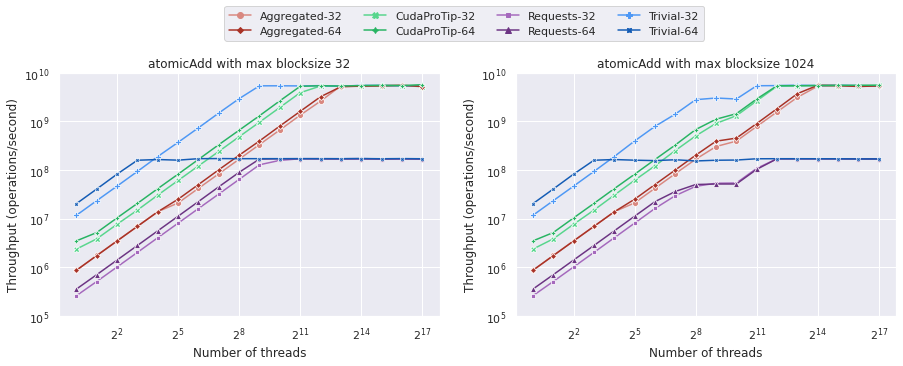

In [67]:
fig, ax =plt.subplots(1,2)
fig.figure.set_size_inches(15, 5)

blocksize = 32
atomicadd1 = readAtomicTimes("../results/atomicadd_singleblock.txt")
atomicadd1 = atomicadd1[(atomicadd1["threads"]<blocksize)]
atomicadd2 = readAtomicTimes("../results/atomicadd.txt")
atomicadd2 = atomicadd2[(atomicadd2["threads"]==blocksize)]
atomicadd = atomicadd1.append(atomicadd2, ignore_index=True)
plotAtomics(atomicadd, x='total_threads', title='atomicAdd with max blocksize 32', ax=ax[0], min=10**5)

blocksize = 1024
atomicadd1 = readAtomicTimes("../results/atomicadd_singleblock.txt")
atomicadd1 = atomicadd1[(atomicadd1["threads"]<blocksize)]
atomicadd2 = readAtomicTimes("../results/atomicadd.txt")
atomicadd2 = atomicadd2[(atomicadd2["threads"]==blocksize)]
atomicadd2 = atomicadd2[(atomicadd2["total_threads"]<=2**17)]
atomicadd = atomicadd1.append(atomicadd2, ignore_index=True)
plotAtomics(atomicadd, x='total_threads', title='atomicAdd with max blocksize 1024', ax=ax[1], min=10**5)

handles, labels = ax[0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.subplots_adjust(top=0.8)
plt.savefig("plots/atomicadd_blocksize1024vs32.svg")

In [78]:

# blocksize = 32
# atomicadd1 = readAtomicTimes("../results/atomicadd_singleblock.txt")
# atomicadd1 = atomicadd1[(atomicadd1["threads"]<blocksize)]
# atomicadd2 = readAtomicTimes("../results/atomicadd.txt")
# atomicadd2 = atomicadd2[(atomicadd2["threads"]==blocksize)]
# atomicadd = atomicadd1.append(atomicadd2, ignore_index=True)
# plotAtomics(atomicadd, x='total_threads')
# plt.savefig("plots/atomics/atomicadd_blocksize32.svg")

In [79]:
# blocksize = 1024
# atomicadd1 = readAtomicTimes("../results/atomicadd_singleblock.txt")
# atomicadd1 = atomicadd1[(atomicadd1["threads"]<blocksize)]
# atomicadd2 = readAtomicTimes("../results/atomicadd.txt")
# atomicadd2 = atomicadd2[(atomicadd2["threads"]==blocksize)]
# atomicadd2 = atomicadd2[(atomicadd2["total_threads"]<=2**17)]
# atomicadd = atomicadd1.append(atomicadd2, ignore_index=True)
# plotAtomics(atomicadd, x='total_threads')
# plt.savefig("plots/atomics/atomicadd_blocksize1024.svg")

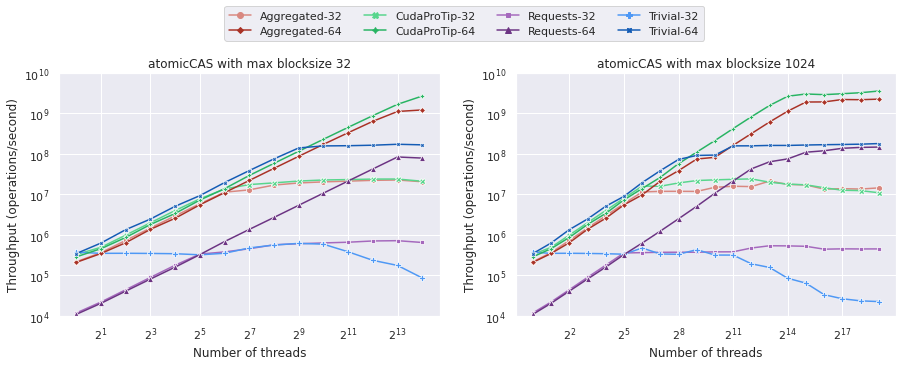

In [68]:
fig, ax =plt.subplots(1,2)
fig.figure.set_size_inches(15, 5)

blocksize = 32
atomiccas_oneblock = readAtomicTimes("../results/atomiccas_singleblock.txt")
atomiccas_oneblock = atomiccas_oneblock[(atomiccas_oneblock["threads"]<blocksize)]
atomiccas = readAtomicTimes("../results/atomiccas.txt")
atomiccas = atomiccas[(atomiccas["threads"]==blocksize)]
atomiccas = atomiccas_oneblock.append(atomiccas, ignore_index=True)
plotAtomics(atomiccas, x='total_threads', title='atomicCAS with max blocksize 32', ax=ax[0])

blocksize = 1024
atomiccas_oneblock = readAtomicTimes("../results/atomiccas_singleblock.txt")
atomiccas_oneblock = atomiccas_oneblock[(atomiccas_oneblock["threads"]<blocksize)]
atomiccas = readAtomicTimes("../results/atomiccas.txt")
atomiccas = atomiccas[(atomiccas["threads"]==blocksize)]
atomiccas = atomiccas_oneblock.append(atomiccas, ignore_index=True)
plotAtomics(atomiccas, x='total_threads', title='atomicCAS with max blocksize 1024', ax=ax[1])

handles, labels = ax[0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1))
plt.subplots_adjust(top=0.8)
plt.savefig("plots/atomiccas_blocksize1024vs32.svg")

In [81]:
# blocksize = 32
# atomiccas_oneblock = readAtomicTimes("../results/atomiccas_singleblock.txt")
# atomiccas_oneblock = atomiccas_oneblock[(atomiccas_oneblock["threads"]<blocksize)]
# atomiccas = readAtomicTimes("../results/atomiccas.txt")
# atomiccas = atomiccas[(atomiccas["threads"]==blocksize)]
# atomiccas = atomiccas_oneblock.append(atomiccas, ignore_index=True)
# plotAtomics(atomiccas, x='total_threads')

# Queues

In [167]:
queue_times = readQueuTimes("../results/queues_final.txt")
cpu_queue_times = readQueuTimes("../results/cpu_queues_final.txt")
cpu_queue_times['name'] = (cpu_queue_times['name'].str
                             .replace('BrokerQueue', 'CPU-BrokerQueue')
                             .replace('CASRingBuffer', 'CPU-CASRingBuffer'))
queue_times = queue_times.append(cpu_queue_times, ignore_index=True)

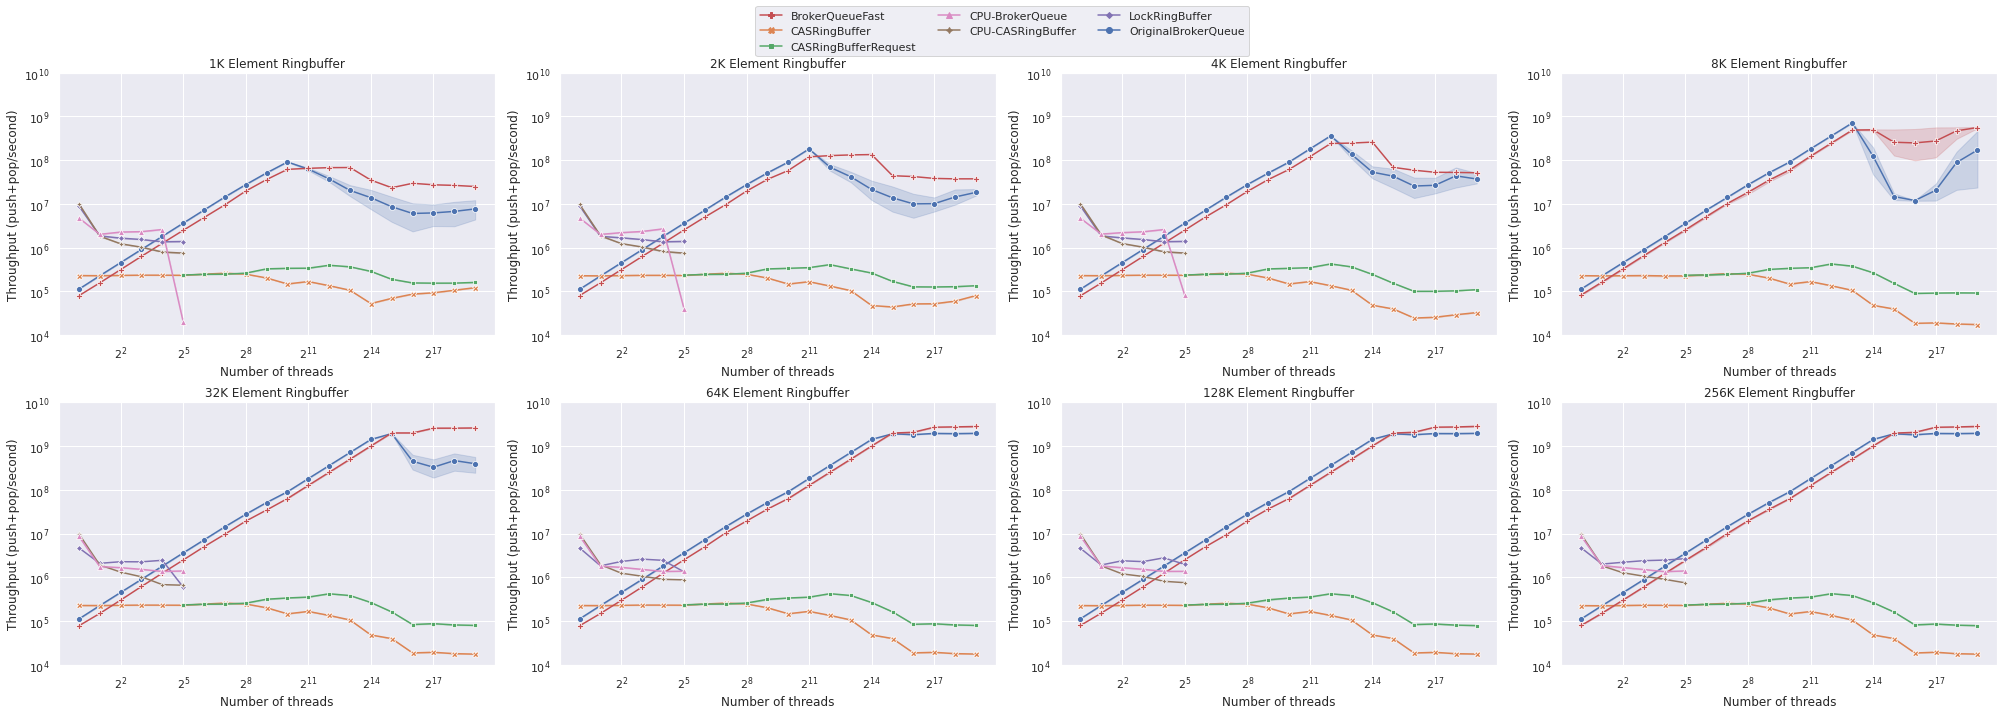

In [168]:
fig, ax =plt.subplots(2,4)
fig.figure.set_size_inches(28, 10)

queue_times1 = queue_times[(queue_times["ringbuffersize"]== 1 * 1024)]
plotQueues(queue_times1, 'total_threads', ax=ax[0,0], title='1K Element Ringbuffer')

queue_times2 = queue_times[(queue_times["ringbuffersize"]== 2 * 1024)]
plotQueues(queue_times2, 'total_threads', ax=ax[0,1], title='2K Element Ringbuffer')

queue_times4 = queue_times[(queue_times["ringbuffersize"]== 4 * 1024)]
plotQueues(queue_times4, 'total_threads', ax=ax[0,2], title='4K Element Ringbuffer')

queue_times8 = queue_times[(queue_times["ringbuffersize"]== 8 * 1024)]
plotQueues(queue_times8, 'total_threads', ax=ax[0,3], title='8K Element Ringbuffer')


queue_times32 = queue_times[(queue_times["ringbuffersize"]== 32 * 1024)]
plotQueues(queue_times32, 'total_threads', ax=ax[1,0], title='32K Element Ringbuffer')
#64
queue_times64 = queue_times[(queue_times["ringbuffersize"]== 64 * 1024)]
plotQueues(queue_times64, 'total_threads', ax=ax[1,1], title='64K Element Ringbuffer')

#128K Element Ringbuffer
queue_times128 = queue_times[(queue_times["ringbuffersize"]== 128 * 1024)]
plotQueues(queue_times128, 'total_threads', ax=ax[1,2], title='128K Element Ringbuffer')

#256K Element Ringbuffer
queue_times256 = queue_times[(queue_times["ringbuffersize"]== 256 * 1024)]
plotQueues(queue_times256, 'total_threads', ax=ax[1,3], title='256K Element Ringbuffer')

handles, labels = ax[0,0].get_legend_handles_labels()
# sort hadles and labels by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1))
fig.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig("plots/queues.svg")


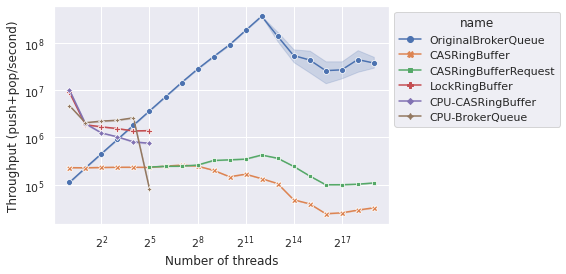

In [113]:
queue_times4 = queue_times[(queue_times["ringbuffersize"]== 4 * 1024)]
plotQueues(queue_times4, 'total_threads')
plt.savefig("plots/queues4.svg")

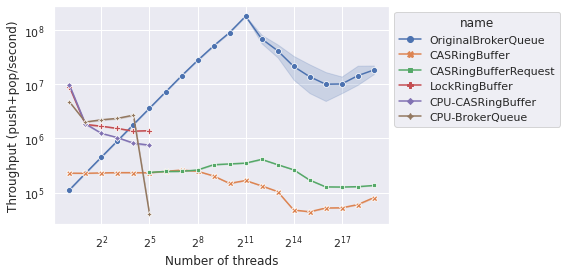

In [114]:
queue_times2 = queue_times[(queue_times["ringbuffersize"]== 2 * 1024)]
plotQueues(queue_times2, 'total_threads')
plt.savefig("plots/queues2.svg")

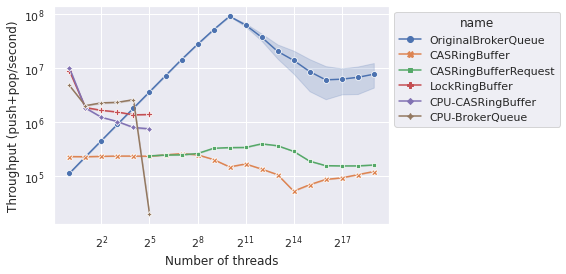

In [115]:
queue_times1 = queue_times[(queue_times["ringbuffersize"]== 1 * 1024)]
plotQueues(queue_times1, 'total_threads')
plt.savefig("plots/queues1.svg")

In [103]:
queue_times = readQueuTimes("../results/queues_final.txt")
cpu_queue_times = readQueuTimes("../results/cpu_queues_final.txt")
cpu_queue_times['name'] = (cpu_queue_times['name'].str
                             .replace('BrokerQueue', 'CPU-BrokerQueue')
                             .replace('CASRingBuffer', 'CPU-CASRingBuffer')
                             .replace('LockRingBuffer', 'CPU-LockRingBuffer'))

queue_times = queue_times.append(cpu_queue_times, ignore_index=True)


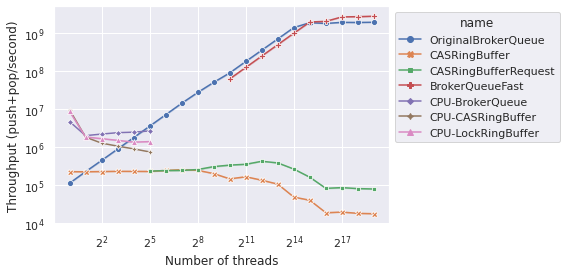

In [104]:
queue_times256 = queue_times[(queue_times["ringbuffersize"]==256 * 1024)]
plotQueues(queue_times256, 'total_threads')
plt.savefig("plots/queues256.svg")

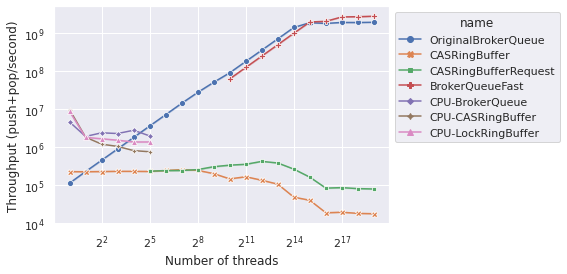

In [105]:
queue_time128 = queue_times[(queue_times["ringbuffersize"]== 128 * 1024)]
plotQueues(queue_time128, 'total_threads')
plt.savefig("plots/queues128.svg")

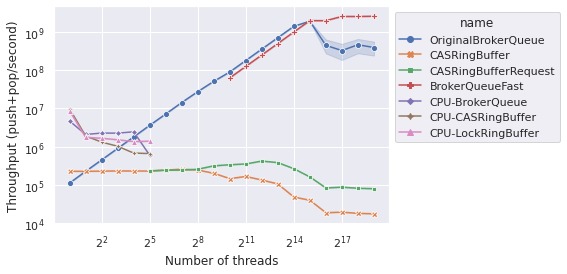

In [106]:
queue_time32 = queue_times[(queue_times["ringbuffersize"]== 32 * 1024)]
plotQueues(queue_time32, 'total_threads')
plt.savefig("plots/queues32.svg")

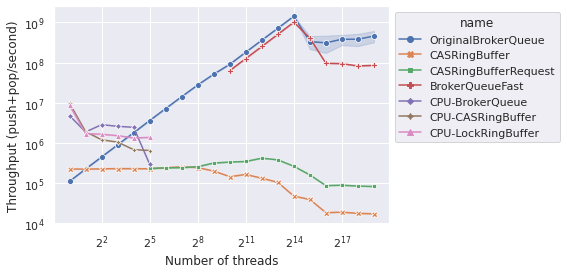

In [107]:
queue_time16 = queue_times[(queue_times["ringbuffersize"]== 16 * 1024)]
plotQueues(queue_time16, 'total_threads')
plt.savefig("plots/queues16.svg")

# HashMaps

In [22]:
def plotHashInsert(df, x, y, logxscale=True):
    plot = sns.lineplot(data=df, x=x, y=y, marker="o",
                        hue=df[['useBuckets', 'probing']].apply(lambda x: (x['probing'] + '-Buckets:' + str(x['useBuckets'])), axis=1))
    
    if logxscale:
        plot.set_xscale('log', base=2)
    
    plot.set(yscale='log')
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    return plot

def plotHashInsertTheir(df, x, y, logxscale=True, ax=None):
    plot = sns.lineplot(data=df, x=x, y=y, marker="o", ax=ax,
                        hue='name', palette="rocket")
    
def name_to_properties(name):
    name, prob, usebucket, groupsize, layout, vecread  = name.split('|')
    usebucket = usebucket.split(':')[1] == '1'
    groupsize = int(groupsize.split(':')[1])
    vecread = int(vecread.split(':')[1])
    return prob, usebucket, groupsize, vecread

def prepareData(hash_times):
    my_times = hash_times[~hash_times['name'].isin(['DycuckooHashTableWrapper', 'WarpCore'])]
    my_times['probing'], my_times['useBuckets'], my_times['groupsize'], my_times['vecread'] = zip(
        *my_times['name'].map(name_to_properties))
    return my_times


# hash_times_c = readHashMapTimes('../results/hash_maps_contiguous_layout.txt2')
# hash_times_c_kv = readHashMapTimes('../results/hash_maps_contiguous_keyval_layout.txt2') 
# hash_times_no_v = readHashMapTimes('../results/hash_maps_novalue.txt2')
hash_times = readHashMapTimes('../results/hash_maps.txt3#')
# my_times_c = prepareData(hash_times_c)
# my_times_c_kv = prepareData(hash_times_c_kv)
# my_times_no_v = prepareData(hash_times_no_v)
my_times = prepareData(hash_times)


their_times = hash_times[hash_times['name'].isin(['DycuckooHashTableWrapper', 'WarpCore'])]


/tmp/ipykernel_210072/3638406419.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_times['probing'], my_times['useBuckets'], my_times['groupsize'], my_times['vecread'] = zip(


<AxesSubplot:xlabel='groupsize', ylabel='insert_qps'>

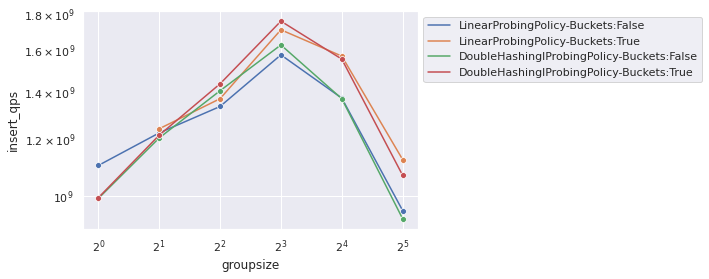

In [19]:
density = 0.8
dens80 = my_times[my_times['load'] == density ]
plotHashInsert(dens80, 'groupsize','insert_qps')


<AxesSubplot:xlabel='groupsize', ylabel='insert_collisions'>

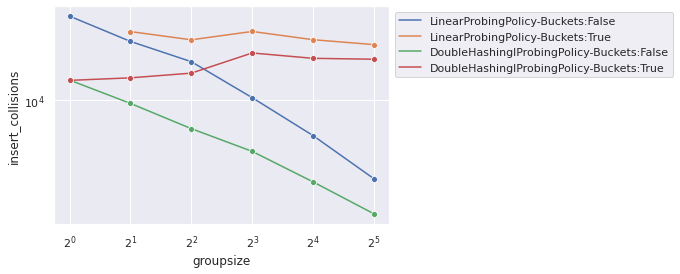

In [31]:
density = 0.9
dens80 = my_times[my_times['load'] == density ]
plotHashInsert(dens80, 'groupsize','insert_collisions')


<AxesSubplot:xlabel='groupsize', ylabel='find_collisions'>

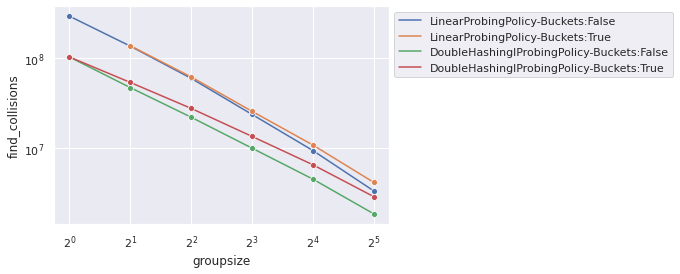

In [32]:
density = 0.9
dens80 = my_times[my_times['load'] == density ]
plotHashInsert(dens80, 'groupsize','find_collisions')

<AxesSubplot:xlabel='groupsize', ylabel='insert_qps'>

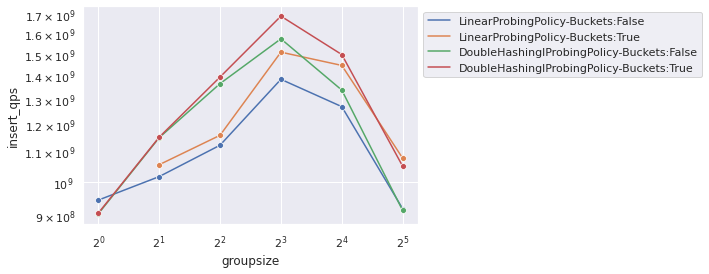

In [30]:
density = 0.9
dens80 = my_times[my_times['load'] == density ]
plotHashInsert(dens80, 'groupsize','insert_qps')


<AxesSubplot:xlabel='groupsize', ylabel='insert_qps'>

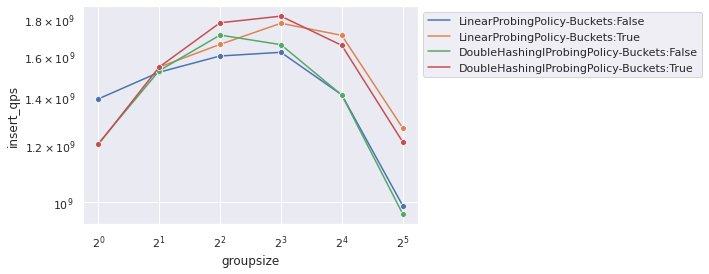

In [40]:
density = 0.80
dens80 = my_times_no_v[my_times_no_v['load'] == density ]
plotHashInsert(dens80, 'groupsize','insert_qps')

<AxesSubplot:xlabel='groupsize', ylabel='insert_qps'>

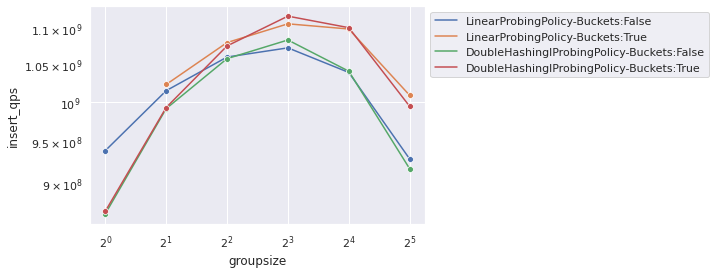

In [30]:
density = 0.80
dens80 = my_times_c[my_times_c['load'] == density ]
plotHashInsert(dens80, 'groupsize','insert_qps')

<AxesSubplot:xlabel='groupsize', ylabel='insert_qps'>

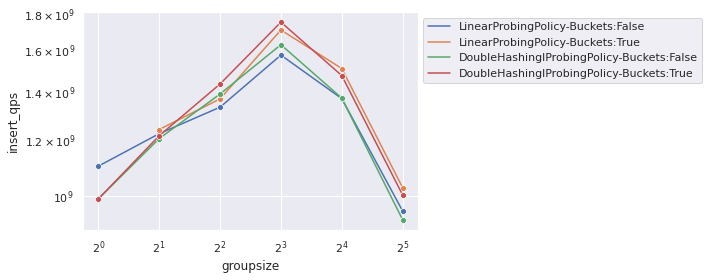

In [31]:
density = 0.80
dens80 = my_times_c_kv[my_times_c_kv['load'] == density ]
plotHashInsert(dens80, 'groupsize','insert_qps')

<AxesSubplot:xlabel='load', ylabel='insert_qps'>

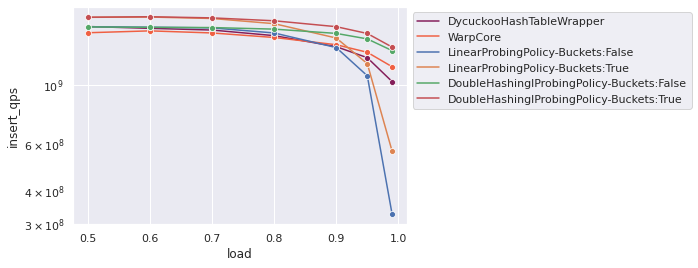

In [32]:
plotHashInsertTheir(their_times, 'load', 'insert_qps', logxscale=False, ax=None)
plotHashInsert(my_times_c_kv[my_times_c_kv['groupsize'] == 8 ], 'load', 'insert_qps', False)


In [20]:
# plotHashInsertTheir(their_times, 'load', 'insert_qps', logxscale=False, ax=None)
# plotHashInsert(my_times[my_times['groupsize'] == 8 ], 'load', 'insert_qps', False)


<AxesSubplot:xlabel='groupsize', ylabel='find_qps'>

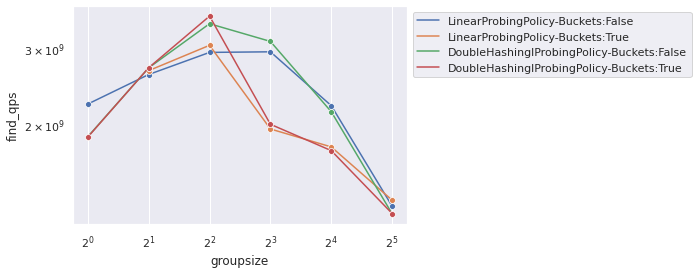

In [33]:
density = 0.80
dens80 = my_times[my_times['load'] == density ]
plotHashInsert(dens80, 'groupsize', 'find_qps')

<AxesSubplot:xlabel='groupsize', ylabel='find_collisions'>

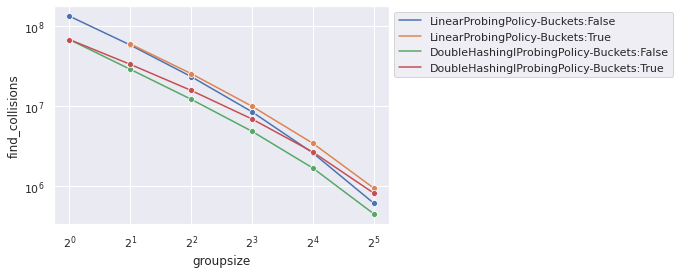

In [12]:
density = 0.8
dens80 = my_times[my_times['load'] == density ]
plotHashInsert(dens80, 'groupsize', 'find_collisions')

<AxesSubplot:xlabel='groupsize', ylabel='find_qps'>

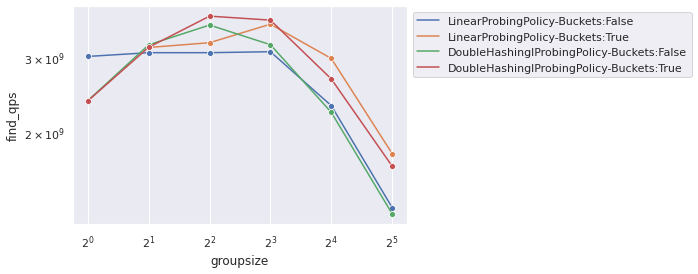

In [41]:
density = 0.80
dens80 = my_times_no_v[my_times_no_v['load'] == density ]
plotHashInsert(dens80, 'groupsize', 'find_qps')

<AxesSubplot:xlabel='groupsize', ylabel='find_qps'>

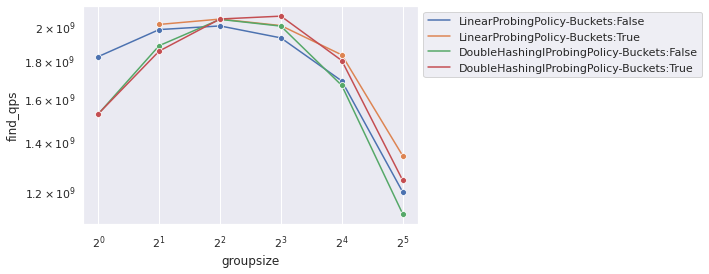

In [34]:
density = 0.80
dens80 = my_times_c[my_times_c['load'] == density ]
plotHashInsert(dens80, 'groupsize', 'find_qps')

<AxesSubplot:xlabel='groupsize', ylabel='find_qps'>

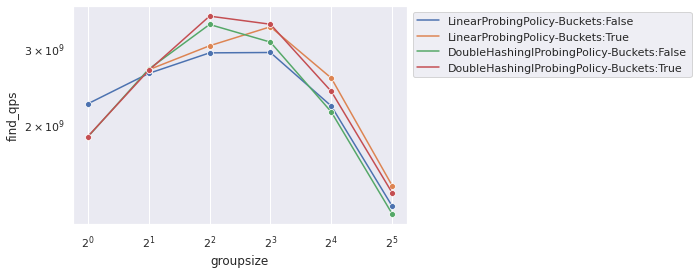

In [35]:
density = 0.80
dens80 = my_times_c_kv[my_times_c_kv['load'] == density ]
plotHashInsert(dens80, 'groupsize', 'find_qps')
# KV KV KV KV

<AxesSubplot:xlabel='load', ylabel='insert_qps'>

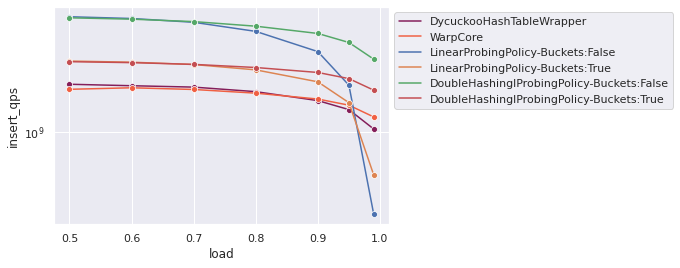

In [36]:
plotHashInsertTheir(their_times, 'load', 'insert_qps', False)
plotHashInsert(my_times[my_times['groupsize'] == 8 ], 'load', 'find_qps', False)

# Graphs

In [3]:
def readBFStimes(file_path):
    names=['graph_name', 'storage', 'algo', 'groupsize', 'time']
    df = pd.read_csv(file_path, names=names, delimiter=' ')
    return df
bfs_times = readBFStimes('../results/real_world_bfs4.txt')

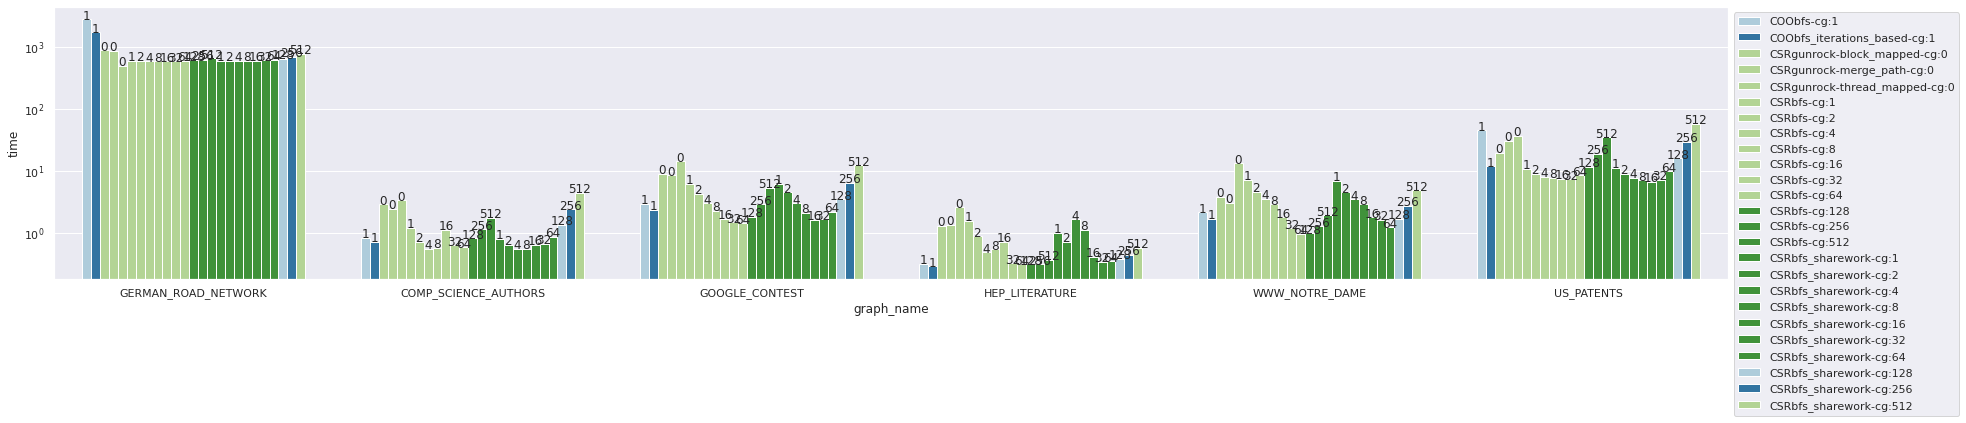

In [4]:
def adjustPalette(palette, repetitions):
    new_palette = []
    i = 0
    for reps in repetitions:
        for j in range(reps):
            new_palette.append(palette[i])
        i += 1
    return new_palette

def plot_bfs(bfs_times):
    plot = sns.barplot(data=bfs_times, x='graph_name', y='time', palette=adjustPalette(sns.color_palette("Paired"), [1,1,10,10]),
                        hue=bfs_times[['storage', 'algo', 'groupsize']].apply(lambda x: (x[0] + x[1] + '-cg:' + str(x[2])), axis=1)  )
    plot.figure.set_size_inches(30, 5)
    plot.set(yscale='log')
    for item in plot.get_xticklabels():
        item.set_rotation(0)
    sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
    labels = []
    for container in plot.containers:
        labels.append(container.get_label())


    # duplicate each element in the list 6 times
    labels = [item for item in labels for i in range(6)]


    for bar, label in zip(plot.patches,labels):
        x = bar.get_x()
        width = bar.get_width()
        height = bar.get_height()
        plot.text(x+width/2., height , label.split(':')[1], ha="center") 
plot_bfs(bfs_times)

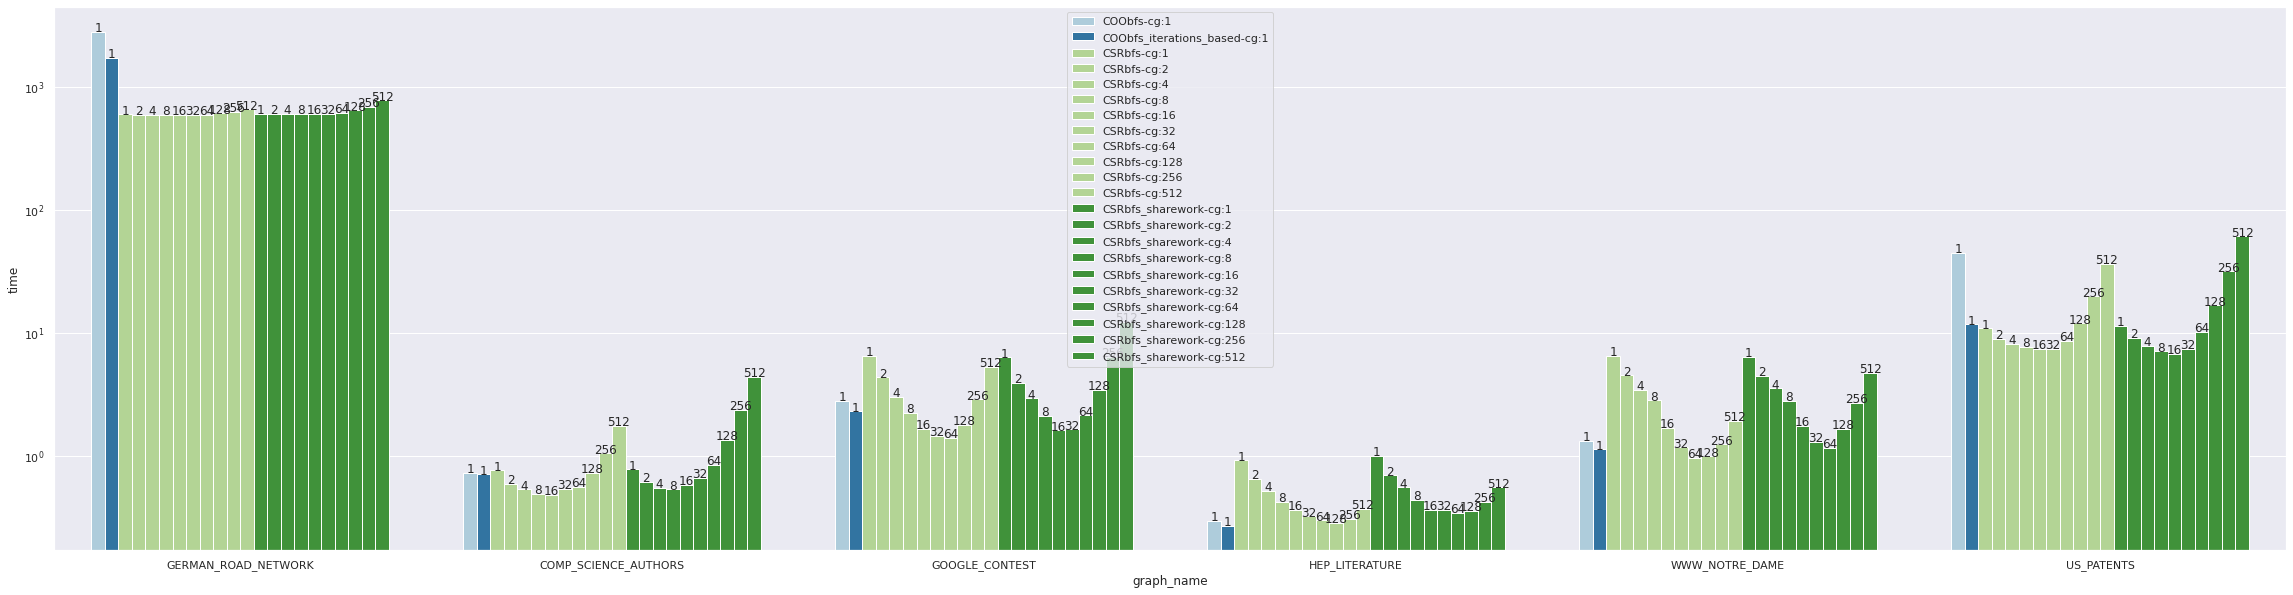

In [20]:
plot_bfs(bfs_times)